# MicroPrice (Stoikov, 2017) calibration for BTCUSDT

In [2]:
# This notebook explores results in the calibration of the MicroPrice (Stoikov, 2017) 
# high frequency estimator in order to be used with crypto pairs like BTCUSDT.
# For more information about MicroPrice refer to Stoikov's paper: 
# https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2970694

import pandas as pd
import numpy as np
%matplotlib inline

from scipy.linalg import block_diag
import matplotlib.pyplot as plt

In [3]:
multiplier = 1000

# Output params
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
plt.rcParams['figure.figsize'] = [20, 10]

In [4]:
def get_df(symbol):
    
    data_file = 'data/FUTURES_%s_DATA.csv'%str(symbol)
    
    df = pd.read_csv(data_file, usecols=[0, 1, 2, 3, 4])
    df.columns = ['time_e','a1','a1size','b1','b1size']
    df = df.rename(columns={'time_e':'time', 'a1':'ask', 'a1size':'as', 'b1':'bid', 'b1size':'bs'})
    df = df.dropna()
    
    df['time'] = df['time'].astype('Int64')
    df['ask'] = df['ask'] / multiplier
    df['as'] = df['as'] / multiplier
    df['bid'] = df['bid'] / multiplier
    df['bs'] = df['bs'] / multiplier
    df['spread'] = round(df['ask'] - df['bid'], 3)
    
    df['mid'] = (df['bid'].astype(float) + df['ask'].astype(float)) / 2
    df['midvar'] = df['mid'].diff(periods=1).round(5) # Midprice variation
    
    df['imb'] = df['bs'].astype(float) / (df['bs'].astype(float) + df['as'].astype(float))
    df['wmid'] = df['ask'].astype(float) * df['imb'] + df['bid'].astype(float) * (1 - df['imb'])
    
    return df

In [5]:
data = get_df('BTCUSDT')
data.head()

,time,ask,as,bid,bs,spread,mid,midvar,imb,wmid
0,1659091337049,24021.9,4.232,24021.8,2.204,0.1,24021.85,NaN,0.342449,24021.834245
1,1659091337084,24021.9,4.223,24021.8,2.208,0.1,24021.85,0.0,0.343337,24021.834334
2,1659091337116,24021.9,4.206,24021.8,2.209,0.1,24021.85,0.0,0.344349,24021.834435
3,1659091337149,24021.9,4.206,24021.8,2.215,0.1,24021.85,0.0,0.344962,24021.834496
4,1659091337181,24021.9,5.408,24021.8,1.111,0.1,24021.85,0.0,0.170425,24021.817042


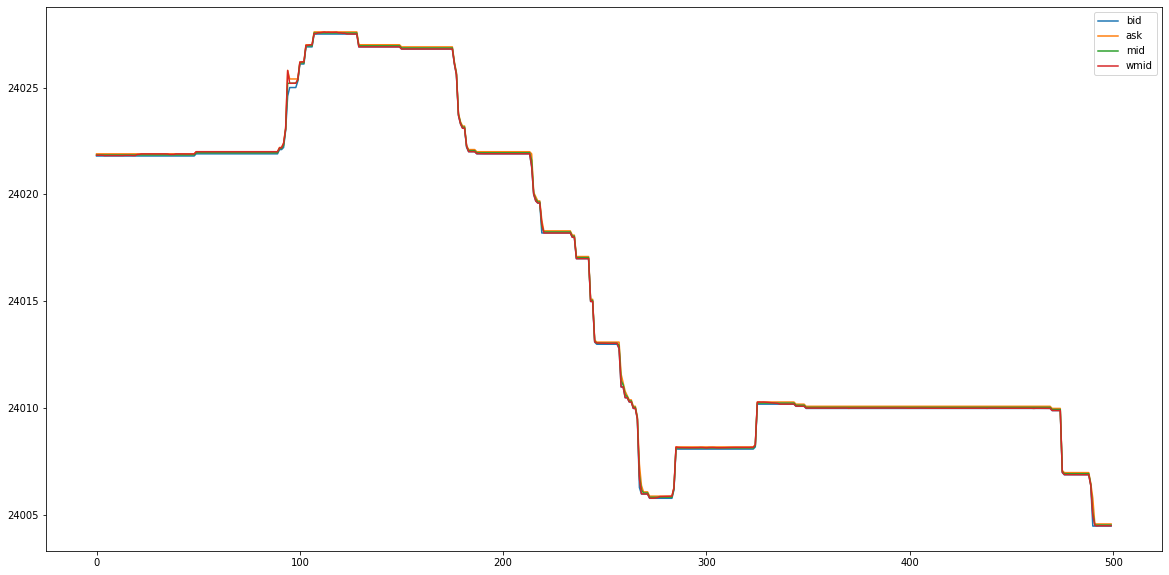

In [6]:
data[['bid', 'ask', 'mid', 'wmid']].head(500).plot();

## Determine the spread states S

In [7]:
print(data.spread.value_counts().head(5))


0.1    2915
0.2      13
0.4       6
0.3       6
0.6       4
Name: spread, dtype: int64


## Tick size calculation

In [8]:
ticksize = np.round(min(data.spread.loc[data.spread > 0]) * 100) / 100
print(ticksize)

0.1


## Determine the minimal observed midprice variations states K

In [9]:
print(data.midvar.abs().value_counts().sort_index().head())

0.00    2785
0.05      10
0.10      33
0.15       7
0.20      15
Name: midvar, dtype: int64


In [10]:
def prep_data_sym(T, n_imb, dt, n_spread):
    
    spread = T.ask - T.bid
    ticksize = np.round(min(spread.loc[spread > 0]) * 100) / 100
    T.spread = T.ask - T.bid
    
    # Adds the spread and mid prices
    T['spread'] = np.round((T['ask'] - T['bid']) / ticksize) * ticksize
    T['mid'] = (T['bid'] + T['ask']) / 2
    
    # Filter out spreads >= n_spread
    T = T.loc[(T.spread <= n_spread*ticksize) & (T.spread>0)]
    T['imb'] = T['bs'] / (T['bs'] + T['as'])
    
    # Discretize imbalance into percentiles
    T['imb_bucket'] = pd.qcut(T['imb'], n_imb, labels=False)
    T['next_mid'] = T['mid'].shift(-dt)

    # Step ahead state variables
    T['next_spread'] = T['spread'].shift(-dt)
    T['next_time'] = T['time'].shift(-dt)
    T['next_imb_bucket'] = T['imb_bucket'].shift(-dt)

    # Step ahead change in price
    T['dM'] = np.round((T['next_mid'] - T['mid']) / ticksize * 2) * ticksize / 2
    T = T.loc[(T.dM <= ticksize * 1.1) & (T.dM >= -ticksize * 1.1)]
    
    # Symetrize data
    T2 = T.copy(deep=True)
    T2['imb_bucket'] = n_imb -1 - T2['imb_bucket']
    T2['next_imb_bucket'] = n_imb -1 - T2['next_imb_bucket']
    T2['dM'] = -T2['dM']
    T2['mid'] = -T2['mid']
    
    T3 = pd.concat([T, T2])
    T3.index = pd.RangeIndex(len(T3.index)) 

    return T3, ticksize

In [11]:
def estimate(T):
    
    no_move = T[T['dM']==0]
    no_move_counts = no_move.pivot_table(index=[ 'next_imb_bucket'], 
                         columns=['spread', 'imb_bucket'], 
                         values='time',
                         fill_value=0, 
                         aggfunc='count').unstack()
    Q_counts = np.resize(np.array(no_move_counts[0:(n_imb*n_imb)]),(n_imb, n_imb))

    # Loop over all spreads and add block matrices
    for i in range(1,n_spread):
        Qi= np.resize(np.array(no_move_counts[(i * n_imb * n_imb):(i + 1) * (n_imb * n_imb)]), (n_imb, n_imb))
        Q_counts = block_diag(Q_counts, Qi)
        
    # Print Q_counts
    move_counts = T[(T['dM'] != 0)].pivot_table(index = ['dM'], 
                         columns=['spread', 'imb_bucket'], 
                         values='time',
                         fill_value=0, 
                         aggfunc='count').unstack()

    R_counts = np.resize(np.array(move_counts),(n_imb * n_spread, 4))
    T1 = np.concatenate((Q_counts, R_counts), axis=1).astype(float)

    for i in range(0,n_imb*n_spread):
        T1[i] = T1[i] / T1[i].sum()
    Q = T1[:,0:(n_imb * n_spread)]
    R1 = T1[:,(n_imb * n_spread):]

    #K=np.array([-0.01, -0.005, 0.005, 0.01])
    K=np.array([-0.1, -0.05, 0.05, 0.1])
    
    move_counts = T[(T['dM'] != 0)].pivot_table(index=['spread','imb_bucket'], 
                     columns=['next_spread', 'next_imb_bucket'], 
                     values='time',
                     fill_value=0, 
                     aggfunc='count') #.unstack()

    R2_counts = np.resize(np.array(move_counts),(n_imb * n_spread,n_imb * n_spread))
    T2 = np.concatenate((Q_counts, R2_counts), axis=1).astype(float)

    for i in range(0,n_imb * n_spread):
        T2[i] = T2[i]/T2[i].sum()

    R2 = T2[:,(n_imb * n_spread):]
    Q2 = T2[:, 0:(n_imb * n_spread)]
    G1 = np.dot(np.dot(np.linalg.inv(np.eye(n_imb * n_spread) - Q), R1), K)
    B = np.dot(np.linalg.inv(np.eye(n_imb * n_spread) - Q), R2)
    
    return G1, B, Q, Q2, R1, R2, K

In [12]:
def plot_Gstar(ticker, G1, B, T):

    G2 = np.dot(B,G1) + G1
    G3 = G2 + np.dot(np.dot(B, B), G1)
    G4 = G3 + np.dot(np.dot(np.dot(B, B), B), G1)
    G5 = G4 + np.dot(np.dot(np.dot(np.dot(B, B), B), B), G1)
    G6 = G5 + np.dot(np.dot(np.dot(np.dot(np.dot(B, B), B), B), B), G1)
    
    #plt.plot(imb,np.linspace(-0.005,0.005,n_imb)*0,label='Mid adj',marker='o')
    #plt.plot(imb,np.linspace(-0.005,0.005,n_imb),label='Weighted mid adj',marker='o')
    
    plt.plot(imb,np.linspace(-0.05, 0.05, n_imb) * 0,label='Mid adj', marker='o')
    plt.plot(imb,np.linspace(-0.05, 0.05, n_imb),label='Weighted mid adj', marker='o')
    
    for i in range(0,n_spread):
        plt.plot(imb, G6[(0 +i * n_imb):(n_imb + i * n_imb)],label="spread = "+str(i+1)+" tick adj", marker='o')
        
    #plt.ylim(-0.005,0.005)
    plt.ylim(-0.05, 0.05)
    
    plt.legend(loc='upper left')
    plt.title(ticker+' adjustments')
    plt.xlabel('Imbalance')
    
    return G6

In [13]:
def pmicro_adjust (mid, imb):
    # print(G6)
    pm = 0

    if imb >= 0 and imb < 0.1:
        pm = mid + G6[0]
        
    if imb >= 0.1 and imb < 0.2:
        pm = mid + G6[1]    
        
    if imb >= 0.2 and imb < 0.3:
        pm = mid + G6[2] 
        
    if imb >= 0.3 and imb < 0.4:
        pm = mid + G6[3] 
        
    if imb >= 0.4 and imb < 0.5:
        pm = mid + G6[4] 
        
    if imb >= 0.5 and imb < 0.6:
        pm = mid + G6[5] 
    
    if imb >= 0.6 and imb < 0.7:
        pm = mid + G6[6] 
        
    if imb >= 0.7 and imb < 0.8:
        pm = mid + G6[7] 
        
    if imb >= 0.8 and imb < 0.9:
        pm = mid + G6[8] 
        
    if imb >= 0.9 and imb <= 1:
        pm = mid + G6[9]
    
    return round(pm,2)
    

## Forecasted midprice adjustments for horizon τ6

In [14]:
n_imb = 10
#n_spread = 2
n_spread = 1
dt = 1
data = get_df('BTCUSDT') 
ticker = 'BTCUSDT'

pd.set_option('mode.chained_assignment', None)
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

T, ticksize = prep_data_sym(data, n_imb, dt, n_spread)

Midprice adjustments:  [-0.04038611 -0.02661843 -0.01661383 -0.00717825  0.00244895 -0.00244895
  0.00717825  0.01661383  0.02661843  0.04038611]


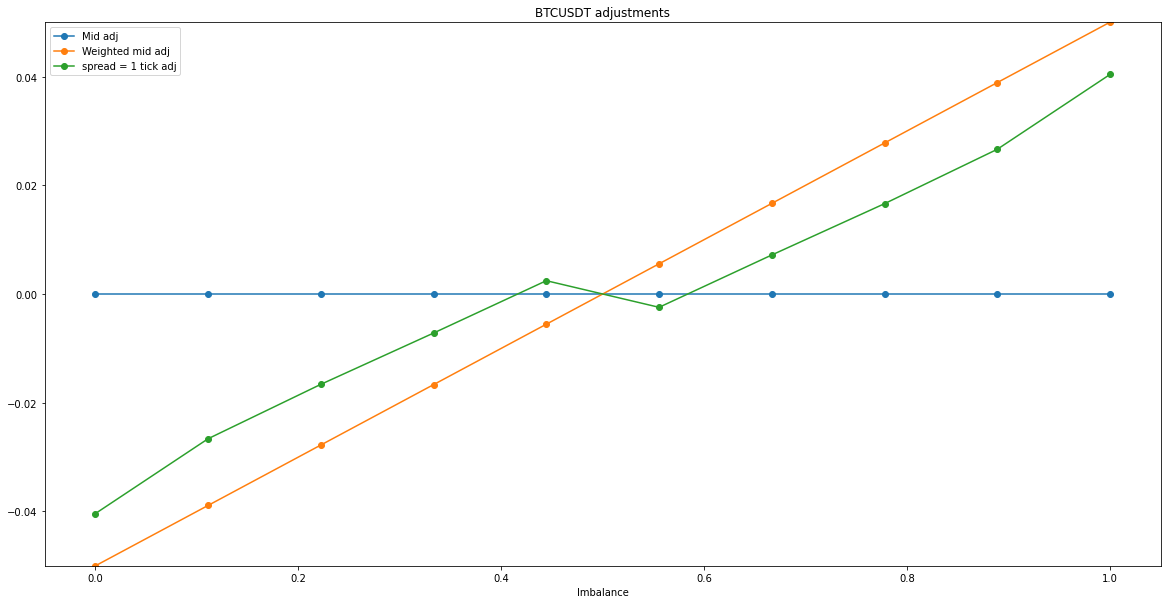

In [15]:
imb = np.linspace(0, 1, n_imb)
G1, B, Q, Q2, R1, R2, K = estimate(T)
G6 = plot_Gstar(ticker, G1, B, T)

print('Midprice adjustments: ', G6)

## Empirical: Convergence at τ6

In [16]:
# Prepares convergence dataframe
df_test = data.dropna()
df_test['pmicro'] = data.apply(lambda row : pmicro_adjust(row['mid'],
                     row['imb']), axis = 1)
df_test['midt6'] = data['mid'].shift(-6)

df_test['forecasted_adjustment'] = df_test['pmicro'] - df_test['mid']
df_test['realized_adjustment'] = df_test['midt6'] - df_test['mid']


<AxesSubplot:>

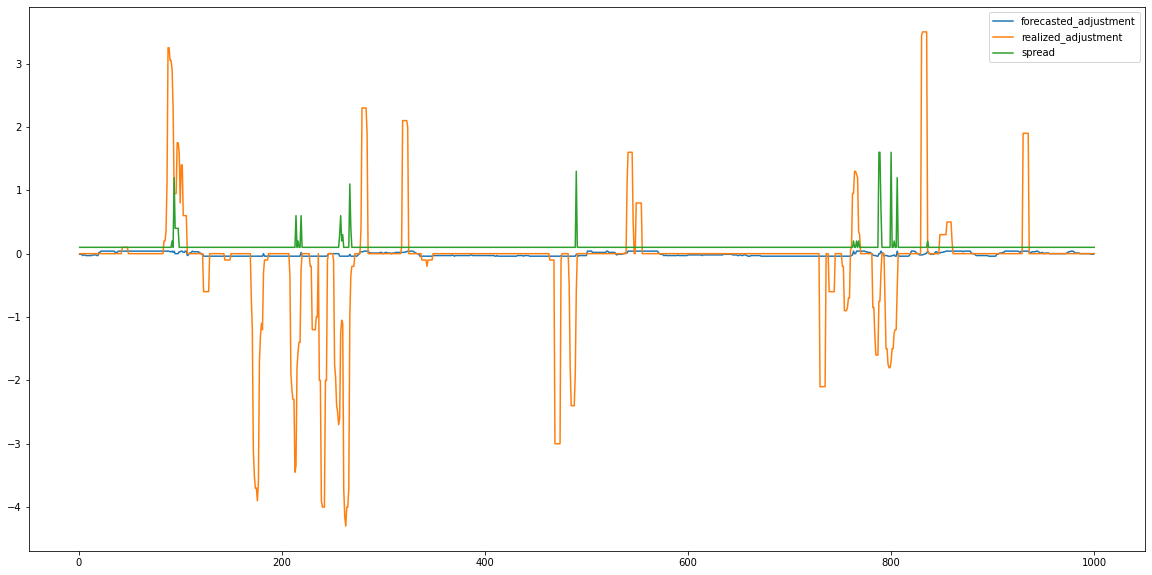

In [17]:
df_test[['forecasted_adjustment', 'realized_adjustment', 'spread']].head(1000).plot()


In [18]:
converged = df_test.query('forecasted_adjustment == realized_adjustment')['time'].count()
no_converged = df_test.query('forecasted_adjustment != realized_adjustment')['time'].count()
converge_percent = converged / (converged + no_converged) * 100

print('Realized: ', converged)
print('No-Realized: ', no_converged)
print('Convergence: ', round(converge_percent,2), '%')

Realized:  280
No-Realized:  2680
Convergence:  9.46 %
